# Programmable illumination: phase contrast

_Srayan Gangopadhyay_  
_Thu 9 Mar 2023_

Sources:
- https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle
- https://stackoverflow.com/questions/38674027/find-the-row-indexes-of-several-values-in-a-numpy-array
- https://stackoverflow.com/questions/34357617/append-2d-array-to-3d-array-extending-third-dimension

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from led_posns import *

## Simulating the LED setup to get the required indices

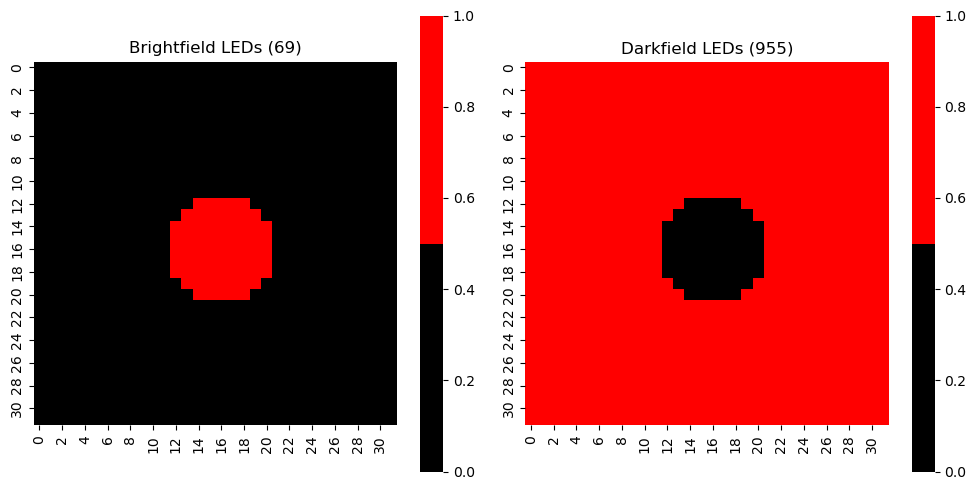

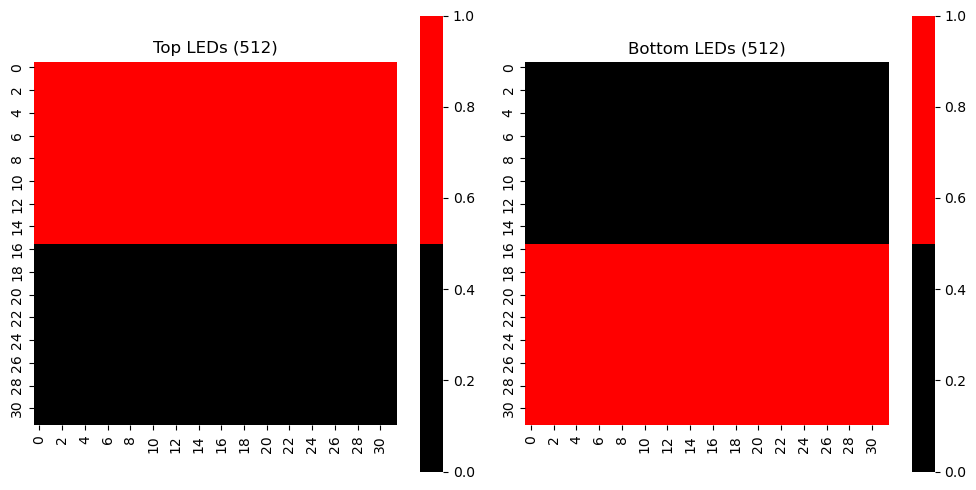

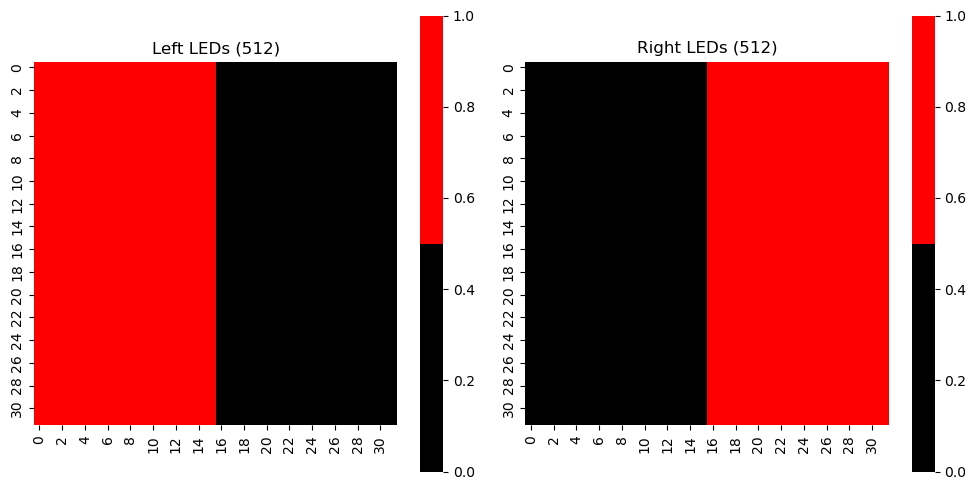

In [2]:
bright_posns, dark_posns, top_posns, bottom_posns, left_posns, right_posns = get_led_posns(32, 5)

In [3]:
top_in_bright = np.where((bright_posns==top_posns[:,None]).all(-1))[1]
top_in_dark = np.where((dark_posns==top_posns[:,None]).all(-1))[1]
bottom_in_bright = np.where((bright_posns==bottom_posns[:,None]).all(-1))[1]
bottom_in_dark = np.where((dark_posns==bottom_posns[:,None]).all(-1))[1]
left_in_bright = np.where((bright_posns==left_posns[:,None]).all(-1))[1]
left_in_dark = np.where((dark_posns==left_posns[:,None]).all(-1))[1]
right_in_bright = np.where((bright_posns==right_posns[:,None]).all(-1))[1]
right_in_dark = np.where((dark_posns==right_posns[:,None]).all(-1))[1]

## Reading in the images

In [4]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 bead phantom raster'

In [5]:
brightfield = io.imread(img_dir + r'\2023-03-08 bead phantom brightfield raster kept stack.tif')[:-1]
darkfield_1 = io.imread(img_dir + r'\2023-03-08 bead phantom darkfield raster.tiff')
darkfield_2 = io.imread(img_dir + r'\2023-03-08 bead phantom darkfield raster_X1.tif')
darkfield = np.concatenate((darkfield_1, darkfield_2))[:-1]

In [6]:
brightfield.shape

(69, 1392, 1040)

In [7]:
darkfield.shape

(955, 1392, 1040)

## Calculating the phase contrast images

Assuming $I_{DPC} = \frac{I_L - I_R}{I_L + I_R}$ (from [here](https://doi.org/10.1371/journal.pone.0124938))

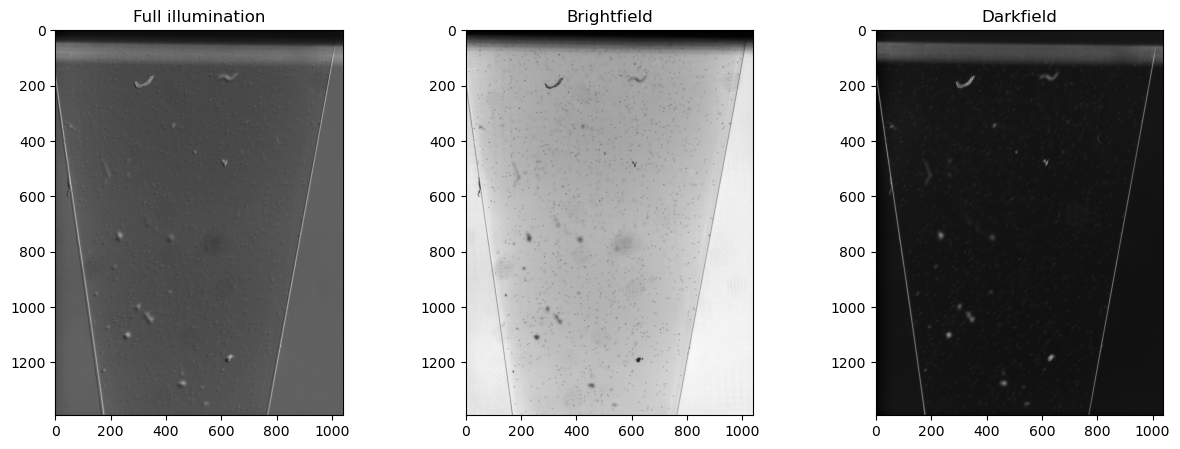

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(np.sum(np.concatenate((brightfield, darkfield)), axis=0), cmap='gray')
axs[0].set_title('Full illumination')
axs[1].imshow(np.sum(brightfield, axis=0), cmap='gray')
axs[1].set_title('Brightfield')
axs[2].imshow(np.sum(darkfield, axis=0), cmap='gray')
axs[2].set_title('Darkfield')
plt.show()

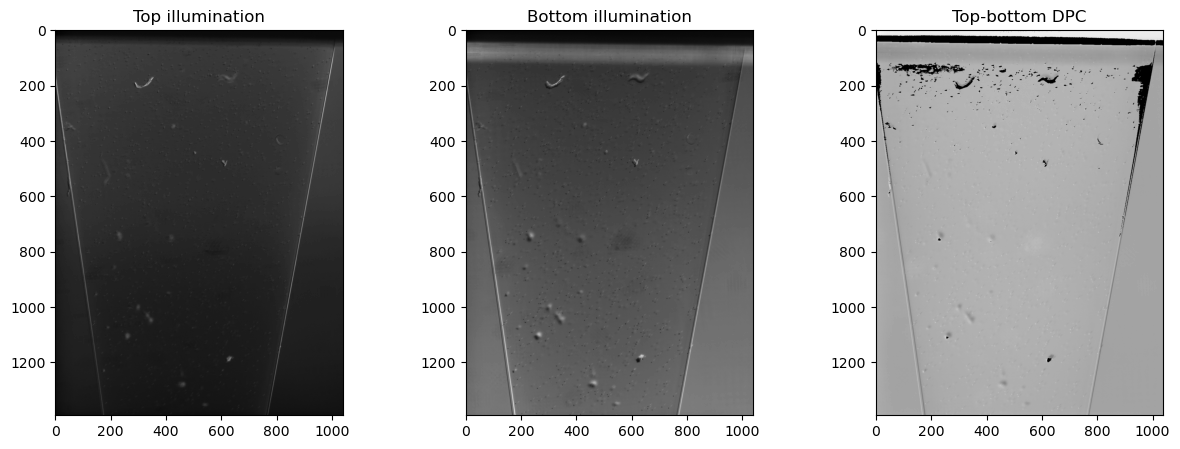

In [9]:
top = np.sum(np.concatenate((brightfield[top_in_bright], darkfield[top_in_dark])), axis=0)
bottom = np.sum(np.concatenate((brightfield[bottom_in_bright], darkfield[bottom_in_dark])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(top, cmap='gray')
axs[0].set_title('Top illumination')
axs[1].imshow(bottom, cmap='gray')
axs[1].set_title('Bottom illumination')
axs[2].imshow((top-bottom)/(top+bottom), cmap='gray')
axs[2].set_title('Top-bottom DPC')
plt.show()

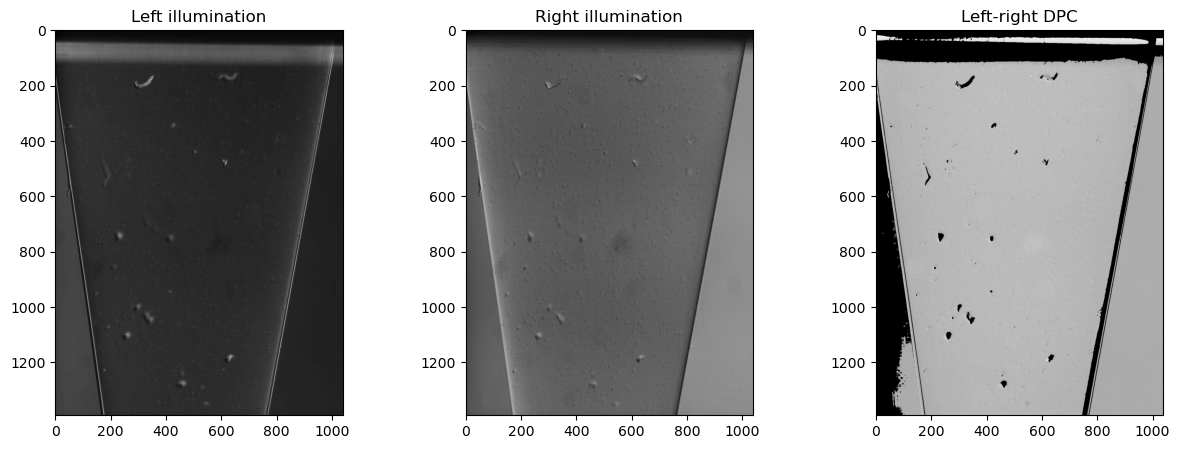

In [10]:
left = np.sum(np.concatenate((brightfield[left_in_bright], darkfield[left_in_dark])), axis=0)
right = np.sum(np.concatenate((brightfield[right_in_bright], darkfield[right_in_dark])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(left, cmap='gray')
axs[0].set_title('Left illumination')
axs[1].imshow(right, cmap='gray')
axs[1].set_title('Right illumination')
axs[2].imshow((left-right)/(left+right), cmap='gray')
axs[2].set_title('Left-right DPC')
plt.show()